## 1. Quá trình dự báo trên mô hình GRU

Thêm thư viện

In [41]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import GRUV2 as GRU
from keras.models import load_model
import investpy
import datetime as dt

Nạp dữ liệu từ file csv

In [42]:

start = '01/06/2021'
end = dt.datetime.now().strftime("%d/%m/%Y")

pre_day = 30
stock="bitcoin"
df = investpy.get_crypto_historical_data(crypto=stock ,from_date=start, to_date=end)
df = pd.DataFrame(df)
df

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2021-06-01,37294.3,37850.3,35742.7,36687.6,113478,USD
2021-06-02,36687.7,38199.9,35981.1,37555.8,96889,USD
2021-06-03,37555.7,39462.3,37193.6,39187.3,106442,USD
2021-06-04,39191.4,39255.4,35659.9,36851.3,127708,USD
2021-06-05,36841.2,37887.6,34832.0,35520.0,101475,USD
...,...,...,...,...,...,...
2022-06-11,29083.3,29426.6,28161.8,28403.4,82917,USD
2022-06-12,28404.0,28534.8,26606.3,26606.3,120024,USD
2022-06-13,26606.3,26857.6,22006.3,22448.0,379257,USD


Chuẩn hóa dữ liệu

In [43]:
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
# Đường Simple Moving Average (SMA)
# là đường trung bình động đơn giản được tính bằng trung bình cộng các mức giá đóng cửa trong một khoảng thời gian giao dịch nhất định.
# Vd MA_7 = Khoảng thời gian (7 ngày về sau tính cả ngày đang tính)
df[f'SMA_{ma_1}'] = df['Close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['Close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['Close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['Close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['Close'].rolling(window=ma_3).std()
df.dropna(inplace=True)

df.to_csv(f"{stock}.csv")
print(df)

               Open     High      Low    Close  Volume Currency     H-L  \
Date                                                                      
2021-06-21  35597.9  35708.4  31284.1  31692.0  256872      USD  4424.3   
2021-06-22  31682.7  33272.5  28901.8  32496.4  309654      USD  4370.7   
2021-06-23  32498.3  34784.3  31736.5  33674.3  173340      USD  3047.8   
2021-06-24  33678.1  35249.9  32356.7  34665.8  119250      USD  2893.2   
2021-06-25  34660.5  35490.9  31337.9  31594.0  193433      USD  4153.0   
...             ...      ...      ...      ...     ...      ...     ...   
2022-06-11  29083.3  29426.6  28161.8  28403.4   82917      USD  1264.8   
2022-06-12  28404.0  28534.8  26606.3  26606.3  120024      USD  1928.5   
2022-06-13  26606.3  26857.6  22006.3  22448.0  379257      USD  4851.3   
2022-06-14  22449.1  23200.3  20860.9  22157.3  251010      USD  2339.4   
2022-06-15  22137.5  22254.6  20125.8  21351.1  220384      USD  2128.8   

               O-C      

Scale Miền giá trị lại

In [44]:
# Process Data
pre_day = 30
scala_x = MinMaxScaler()
scala_y = MinMaxScaler()
cols_x = ['H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['Close']
# 7 giá trị của côt x sẽ để dự đoán cho Close của ngày thứ i
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))
# scaled_data_x
scaled_data_y

array([[0.22394146],
       [0.24136146],
       [0.26686994],
       [0.28834176],
       [0.22181918],
       [0.23588252],
       [0.28861679],
       [0.28422931],
       [0.31365534],
       [0.29616171],
       [0.26403952],
       [0.26988228],
       [0.29000927],
       [0.30203695],
       [0.2671623 ],
       [0.27880884],
       [0.27106036],
       [0.24937198],
       [0.26953578],
       [0.26332487],
       [0.27885432],
       [0.25471449],
       [0.24637913],
       [0.24838447],
       [0.22715736],
       [0.217488  ],
       [0.22018633],
       [0.22596412],
       [0.20543   ],
       [0.18283424],
       [0.23345706],
       [0.23708442],
       [0.26533237],
       [0.27012916],
       [0.30404879],
       [0.34488098],
       [0.39199122],
       [0.40392795],
       [0.40388897],
       [0.45157525],
       [0.43750541],
       [0.40122313],
       [0.3858496 ],
       [0.36336862],
       [0.39816098],
       [0.42263864],
       [0.46439554],
       [0.503

In [45]:
x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])
x_total
y_total

[array([0.23345706]),
 array([0.23708442]),
 array([0.26533237]),
 array([0.27012916]),
 array([0.30404879]),
 array([0.34488098]),
 array([0.39199122]),
 array([0.40392795]),
 array([0.40388897]),
 array([0.45157525]),
 array([0.43750541]),
 array([0.40122313]),
 array([0.3858496]),
 array([0.36336862]),
 array([0.39816098]),
 array([0.42263864]),
 array([0.46439554]),
 array([0.50378329]),
 array([0.48599513]),
 array([0.5399508]),
 array([0.5249974]),
 array([0.52435855]),
 array([0.49921822]),
 array([0.57297171]),
 array([0.55721488]),
 array([0.55526152]),
 array([0.5337139]),
 array([0.50545945]),
 array([0.50615677]),
 array([0.55016372]),
 array([0.60577823]),
 array([0.59607205]),
 array([0.60427314]),
 array([0.6104494]),
 array([0.57092739]),
 array([0.59864261]),
 array([0.55180307]),
 array([0.60015419]),
 array([0.59653332]),
 array([0.59394111]),
 array([0.55529183]),
 array([0.55827385]),
 array([0.59485066]),
 array([0.60470193]),
 array([0.62039596]),
 array([0.61865

Tách tập dữ liệu thành train và test

In [46]:
import math
test_size = math.floor(len(df)*0.2)
x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(258, 30, 7) (258, 1) (72, 30, 7) (72, 1)


In [47]:
# Build Model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=60, steps_per_epoch=40, use_multiprocessing=True)
model.save(f"{stock}.h5")
print("Done Training Model")

Epoch 1/60
40/40 [==============================] - 13s 51ms/step - loss: 0.0411
Epoch 2/60
40/40 [==============================] - 2s 47ms/step - loss: 0.0143
Epoch 3/60
40/40 [==============================] - 2s 40ms/step - loss: 0.0133
Epoch 4/60
40/40 [==============================] - 2s 44ms/step - loss: 0.0128
Epoch 5/60
40/40 [==============================] - 1s 37ms/step - loss: 0.0082
Epoch 6/60
40/40 [==============================] - 2s 40ms/step - loss: 0.0112
Epoch 7/60
40/40 [==============================] - 2s 40ms/step - loss: 0.0078
Epoch 8/60
40/40 [==============================] - 2s 41ms/step - loss: 0.0073
Epoch 9/60
40/40 [==============================] - 2s 41ms/step - loss: 0.0057
Epoch 10/60
40/40 [==============================] - 2s 43ms/step - loss: 0.0059
Epoch 11/60
40/40 [==============================] - 2s 42ms/step - loss: 0.0067
Epoch 12/60
40/40 [==============================] - 2s 46ms/step - loss: 0.0067
Epoch 13/60
40/40 [=================

3/3 [==============================] - 2s 11ms/step


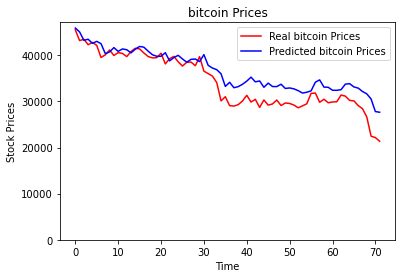

In [48]:

from tensorflow import keras
model = keras.models.load_model(f'{stock}.h5')
predict_prices = model.predict(x_test)
predict_prices = scala_y.inverse_transform(predict_prices)
# trả về giá thực không còn scale nữa

# Ploting the Stat
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1, 1)
real_price = np.array(real_price)
real_price = real_price.reshape(real_price.shape[0], 1)

plt.plot(real_price, color="red", label=f"Real {stock} Prices")
plt.plot(predict_prices, color="blue", label=f"Predicted {stock} Prices")
plt.title(f"{stock} Prices")
plt.xlabel("Time")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()
plt.close()



Đánh giá mô hình

In [49]:
mae = mean_absolute_error(predict_prices, real_price)
mape = mean_absolute_percentage_error(predict_prices, real_price)
mse = mean_squared_error(predict_prices, real_price)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")



MAE: 2489.81
MAPE: 7.32%
MSE: 9411470.45
RMSE: 3067.81
